In [ ]:
from sensible_raw.loaders import loader
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import OneClassSVM
from collections import Counter, defaultdict
import sys
from datetime import datetime as dt
import json
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from build_dataset.extractors.sms_extractor import Sms_extractor
from build_dataset.extractors.stop_locations_extractor import Stop_locations_extractor
from build_dataset.extractors.screen_extractor import Screen_extractor
##from facebook_friends_extractor import Facebook_friends_extractor
from build_dataset.extractors.bluetooth_extractor import Bluetooth_extractor
##from calllog_extractor import Calllog_extractor
##from location_extractor import Location_extractor
from build_dataset.extractors.big_five_extractor import Big_five_extractor

from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd
from build_dataset.analysis.location_reference import Load_location_reference
#from analysis.social_state_reference import Load_social_state_reference
from build_dataset.analysis.consensus_archetypes import Consensus_archetypes

In [ ]:
from pareto_clustering.cluster.build_S import Build_S
from pareto_clustering.cluster import cluster_Infomap

In [3]:
# tc0: School periods (when there are lectures)
# tc1: Exam periods
# tc2: Holiday periods

tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]}
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]}
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]}

In [4]:
location_reference = Load_location_reference(tc1, auxlabel="tc1_", load_reference=True)
#social_state_reference = Load_social_state_reference(tc1, auxlabel="tc1_", load_reference=False)

[location_reference] Loading datasource from local.


In [5]:
load_datasources_from_local = True

sms = Sms_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_datasources_from_local)
stop_locations = Stop_locations_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_datasources_from_local)
screen = Screen_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_datasources_from_local)
##facebook_friends = Facebook_friends_extractor()
bluetooth = Bluetooth_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_datasources_from_local)
##calllog = Calllog_extractor()
##location = Location_extractor()
big_five = Big_five_extractor()

[sms] Loading datasource from local.
[sms] Number of datapoints in range: 1786225
[stop_locations] Loading datasource from local.
[stop_locations] Number of datapoints in range: 450662
[screen] Loading datasource from local.
[screen] Number of datapoints in range: 20211170
[bluetooth] Loading datasource from local.
[bluetooth] Number of datapoints in range: 3312659
[big_five_extractor] Loaded data from local copy!


In [6]:
#tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]} #in school
#location_reference = Load_location_reference(tc1, auxlabel="tc1_", load_reference=False)

### Build full JSON dataset

In [7]:
def build_json_dataset(load_cached_data_sets=True):
    """Build json dataset with key for every user
    
    Loop over user-ids and for each one, collect features from the
    extractors. That's basically it.
    
    Parameters
    ----------
    load_cached_data_sets : bool
        Option to load prebuilt json datasets and just return those
        or to build them from scratch again. Note that building from
    """
    
    # Collect a list of valid user-ids
    with open('data_cache/users.json', 'r') as infile:
        users = [int(i) for i in json.load(infile)]

    if load_cached_data_sets:
        with open('data_cache/dataset_X.json') as infile:
            dataset_X = json.load(infile)
        with open('data_cache/dataset_Y.json') as infile:
            dataset_Y = json.load(infile)
    else:
        dataset_X = {}
        dataset_Y = {}

        for user in users:

            if user%10 == 0:
                print user,

            datapoint_x = {}
            datapoint_y = {}

            # Ordered by fail/execution speed
            try:
                datapoint_x.update(bluetooth.main(user))
                datapoint_x.update(stop_locations.main(user))
                datapoint_x.update(sms.main(user))
                datapoint_x.update(screen.main(user))
                #datapoint_x.update(facebook_friends.main(user))
                #datapoint_x.update(calllog.main(user))
                #datapoint_x.update(location.main(user))
                datapoint_y.update(big_five.main(user))
            except Exception as e:
                print "<"+str(e)+">",
                continue

            dataset_X[user] = datapoint_x
            dataset_Y[user] = datapoint_y

        # Store loaded data    
        with open('data_cache/dataset_X.json', 'w') as outfile:
            json.dump(dataset_X,outfile)
        with open('data_cache/dataset_Y.json', 'w') as outfile:
            json.dump(dataset_Y,outfile)  
    
    return dataset_X, dataset_Y


dataset_X, dataset_Y = build_json_dataset()

### Convert to matrix and standardize

In [8]:
features_x = sorted(dataset_X.items()[0][1].keys())
features_y = ['OE','Co','Ex','Ag','Ne']

X = []
Y = []
for k,v in dataset_X.items():
    X.append([v[f] for f in features_x])
for k,v in dataset_Y.items():
    Y.append([v[f] for f in features_y])
    
X_scaled = scale(np.array(X))
Y = np.array(Y)
M = Consensus_archetypes().project_to_archetype_space(Y)

In [97]:
# Feature reference 
dict(zip(range(len(features_x)),features_x))

{0: u'tc0_bluetooth_social_entropy',
 1: u'tc0_screen_session_duration',
 2: u'tc0_screen_session_frequency',
 3: u'tc0_screen_summed_usage',
 4: u'tc0_sms_fractions_of_conversations_started',
 5: u'tc0_sms_overall_received_responsiveness',
 6: u'tc0_sms_overall_responsiveness',
 7: u'tc0_sms_selectivity_in_responsiveness',
 8: u'tc0_sms_traffic',
 9: u'tc0_stop_locations_geospacial_entropy'}

### Remove outliers

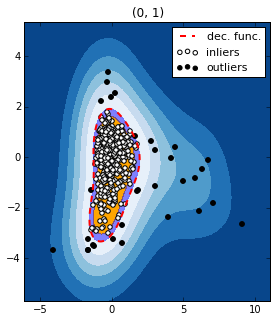

(627, 10)
(596, 10)


In [116]:
#out_svm = Outlier_detector_svm(X_scaled[:,[5,7]], hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_kd = Outlier_detector_kd(X_scaled[:,[6,7]], visualize=True, threshold=0.08, bandwidth=2, kernel='exponential')
outliers = out_kd.main()

X_clean = np.delete(X_scaled,outliers,axis=0)
Y_clean = np.delete(Y,outliers,axis=0)
M_clean = np.delete(M,outliers,axis=0)

print "Removed %d outliers, clean subset has %d samples" % (
    (X_scaled.shape[0]-X_clean.shape[0]), X_clean.shape[0])

### Save data

In [ ]:
np.savetxt("data/X.csv", X_scaled, delimiter=",")
np.savetxt("data/Y.csv", Y, delimiter=",")
np.savetxt("data/X_clean.csv", X_clean, delimiter=",")
np.savetxt("data/Y_clean.csv", Y_clean, delimiter=",")
np.savetxt("data/M.csv", M, delimiter=",")

### Pareto clustering

In [ ]:
_, T, _ = Build_S(X_scaled,10,sample_size=1.0, remove_outliers=True).main(visualize=False)
clusters = cluster_Infomap.community_detection_Infomap(T)

### Create datasets for each cluster

In [ ]:
X_all = []
for clu, traits in clusters.items():
    Xc = X_clean[:,traits]
    X_all.append(Xc)
    
for i, Xc in enumerate(X_all):
    np.savetxt("data/X%s.csv" % i, Xc, delimiter=",")